## Clustering And Classifying The People Opinions About The War In 2023

---


### Objective

1. Collecting and clustering the opinions about the war data
2. Analyze the war data to opinions about war side
3. Cleaning and building the model to predict the data


### About The Data Set


1.  This People opinions about war data was collected using Reddit API. The data was collected from various Reddit subreddit's.

2.   It contains more than 100k data.

### Importing and Installing all the necessary Packages

In [1]:
!pip install gensim
!pip install sketch
!pip install dataprep
!pip install -q -U keras-tuner

In [ ]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import simple_preprocess

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer as Detok
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import sketch
from dataprep.eda import plot
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from tqdm import tqdm
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import silhouette_samples, silhouette_score


import tensorflow as tf

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow import keras
import keras_tuner as kt
from keras.utils import to_categorical


import pickle
import os

mpl.style.use(['ggplot'])

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

### Importing Data Set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Reddit_data.csv')

### Data Exploration and Cleaning

In [ ]:
df.head()

comments
0  This is not a political battle ground subreddi...
1  I believe "release the hostages" has passed th...
2  I think the fact that it happened so far away ...
3  I mean, pretty sure it's just assumed that eve...
4  If Hamas were to release the hostages and turn...

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20126 entries, 0 to 20125
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  20126 non-null  object
dtypes: object(1)
memory usage: 157.4+ KB


In [2]:
plot(df)

In [ ]:
for i in range(5):
    print(df.comments[i])

This is not a political battle ground subreddit. Please read the rules before commenting. Total Karma and account age threshold required to post and comment.


*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/BreakingPointsNews) if you have any questions or concerns.*
I believe "release the hostages" has passed through the lips of just about everyone I've talked to about this. Who are you hanging out with to have a different experience?
I think the fact that it happened so far away just helps these people support hamas/palestine in its actions. If Mexican Cartels had invaded America to attack a rave at the border, kidnapped everyone they could, and shot everyone they couldn't take including children disabled and elderly, you bet your fucking ass America would have invaded Mexico and just glassed entire areas.
I mean, pretty sure it's just assumed that everyone wants terrorists to stop doing terrorism. Wh

In [ ]:
lemmatizer=WordNetLemmatizer()
stop_words = set(stopwords.words('english'))- set(['again', 'once', 'from','not'])

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Remove special characters and lowercase the text
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Lemmatization and removing stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # Join the tokens back into a sentence
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Example usage on 'self_text' column of your DataFrame
df['clean_text'] = df['comments'].apply(lambda x: clean_text(x) if isinstance(x, str) else '')

<ipython-input-10-c38ea4f25f8f>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [ ]:
# Creating a corpus

corpus = []

for i in range(0, len(df)):
    # Ensure 'self_text' is a string
    text = str(df['comments'][i])

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Remove special characters and lowercase the text
    review = re.sub('[^a-zA-Z0-9]', ' ', text)
    review = review.lower()
    review = review.split()

    # Lemmatization and removing stopwords
    review = [lemmatizer.lemmatize(word) for word in review if word not in stop_words]
    review = ' '.join(review)
    corpus.append(review)


<ipython-input-11-319f7512984a>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


### Sentiment Analysis using VADER

In [ ]:
# Initialize the Sentiment Intensity Analyzer
analyzer = SentimentIntensityAnalyzer()

# Declare variables for scores
scores = {
    "Compound": [],
    "Positive": [],
    "Negative": [],
    "Neutral": []
}

# Generate sentiment scores for Reddit comments
for comment in df['clean_text']:
    compound = analyzer.polarity_scores(comment)["compound"]
    pos = analyzer.polarity_scores(comment)["pos"]
    neu = analyzer.polarity_scores(comment)["neu"]
    neg = analyzer.polarity_scores(comment)["neg"]

    scores["Compound"].append(compound)
    scores["Positive"].append(pos)
    scores["Negative"].append(neg)
    scores["Neutral"].append(neu)

# Create a new DataFrame for sentiment scores
sentiments_score = pd.DataFrame(scores)

# Join the sentiment scores DataFrame with the original DataFrame
df = pd.concat([df, sentiments_score], axis=1)

In [ ]:
df.head()

comments  \
0  This is not a political battle ground subreddi...   
1  I believe "release the hostages" has passed th...   
2  I think the fact that it happened so far away ...   
3  I mean, pretty sure it's just assumed that eve...   
4  If Hamas were to release the hostages and turn...   

                                          clean_text  Compound  Positive  \
0  not political battle ground subreddit please r...    0.6988     0.220   
1  believe release hostage passed lip everyone iv...    0.0000     0.000   
2  think fact happened far away help people suppo...    0.3182     0.124   
3  mean pretty sure assumed everyone want terrori...   -0.9186     0.215   
4  hamas release hostage turn war would tragedy h...   -0.6486     0.185   

   Negative  Neutral  
0     0.000    0.780  
1     0.000    1.000  
2     0.071    0.805  
3     0.563    0.222  
4     0.217    0.598

In [ ]:
# Define conditions for sentiment categories based on 'Compound' scores
# If Compound score is <= -0.5, classify as 'Negative'
# If Compound score is > -0.5 and < 0.5, classify as 'Neutral'
# If Compound score is >= 0.5, classify as 'Positive'
conditions = [
    (df['Compound'] <= -0.5),
    (df['Compound'] > -0.5) & (df['Compound'] < 0.5),
    (df['Compound'] > 0.5)
]

# Define corresponding values for each condition
values = ['Negative', 'Neutral', 'Positive']

# Create a new column 'Category' using np.select to assign values based on the conditions
df['Category'] = np.select(conditions, values)

In [ ]:
df.head()

comments  \
0  This is not a political battle ground subreddi...   
1  I believe "release the hostages" has passed th...   
2  I think the fact that it happened so far away ...   
3  I mean, pretty sure it's just assumed that eve...   
4  If Hamas were to release the hostages and turn...   

                                          clean_text  Compound  Positive  \
0  not political battle ground subreddit please r...    0.6988     0.220   
1  believe release hostage passed lip everyone iv...    0.0000     0.000   
2  think fact happened far away help people suppo...    0.3182     0.124   
3  mean pretty sure assumed everyone want terrori...   -0.9186     0.215   
4  hamas release hostage turn war would tragedy h...   -0.6486     0.185   

   Negative  Neutral  Category  
0     0.000    0.780  Positive  
1     0.000    1.000   Neutral  
2     0.071    0.805   Neutral  
3     0.563    0.222  Negative  
4     0.217    0.598  Negative

### Exploratory Data Analysis

In [3]:
plot(df[['Positive', 'Negative', 'Neutral']])

In [ ]:
df.isnull().sum()

comments      0
clean_text    0
Compound      0
Positive      0
Negative      0
Neutral       0
Category      0
dtype: int64

In [ ]:
# Group the DataFrame by 'Category' and count the occurrences of each category
category_counts = df.groupby(['Category'])['Category'].count()

# Create a DataFrame with counts and rename the column to 'Counts'
counts_df = pd.DataFrame(category_counts).rename(columns={"Category": "Counts"})

# Calculate the percentage for each category and add it as a new column 'Percentage'
counts_df['Percentage'] = (counts_df['Counts'] / counts_df['Counts'].sum()) * 100

#counts_df = counts_df.drop(index='0')

# Print or return the summary DataFrame
print(counts_df)

          Counts  Percentage
Category                    
0              2    0.009937
Negative    5878   29.206002
Neutral    11111   55.207195
Positive    3135   15.576866


In [ ]:
counts_df

Counts  Percentage
Category                    
0              2    0.009937
Negative    5878   29.206002
Neutral    11111   55.207195
Positive    3135   15.576866

In [ ]:
# Pie Chart of Sentiment Counts

In [ ]:
# Create a Pie Chart using Plotly
fig = px.pie(counts_df, values='Counts', names=counts_df.index,
             labels={'Category': 'Sentiment Category', 'Counts': 'Count'},
             title='Distribution of Sentiment Categories in Comments',
             hole=0.3,
             color_discrete_sequence=px.colors.qualitative.Set1)

# Set the background color of the Pie Chart to dark grey
fig.update_layout(paper_bgcolor='darkgrey')


# Show the Plotly Pie Chart
fig.show()

#### Positive Comment

In [4]:
plot(df.query('Positive >= 0.5'), 'comments')

#### Negative Comment

In [5]:
plot(df.query('Negative >= 0.5'), 'comments')

#### Neutral Comment

In [6]:
plot(df.query('Neutral >= 0.5'), 'comments')

#### Comments With High Upvotes

#### Plotting the comments based on Compound

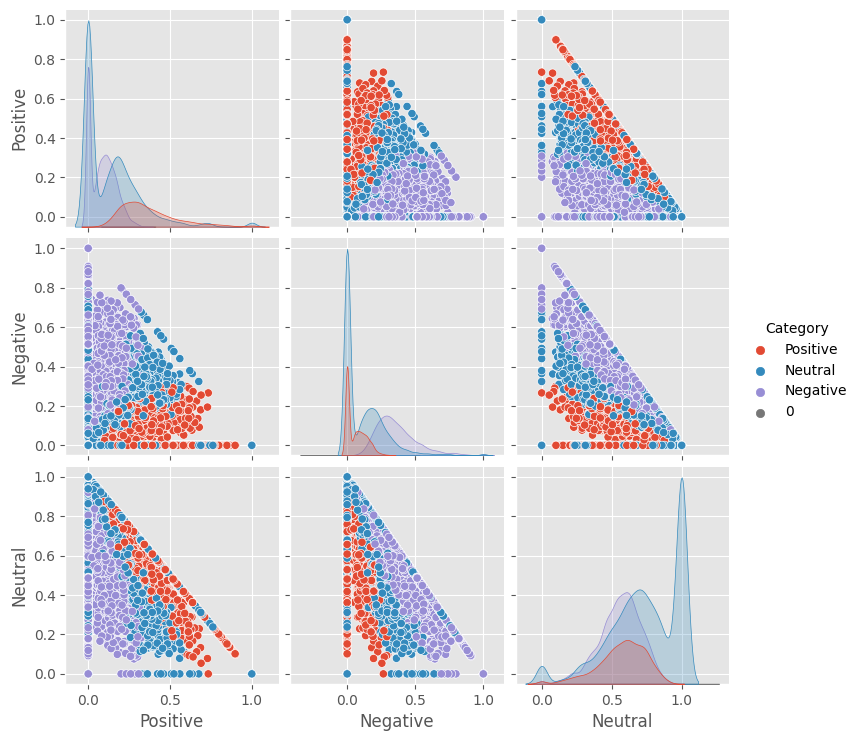

In [ ]:
sns.pairplot(df, vars=['Positive', 'Negative', 'Neutral'],hue='Category')

#### WordCloud of All Sentiments

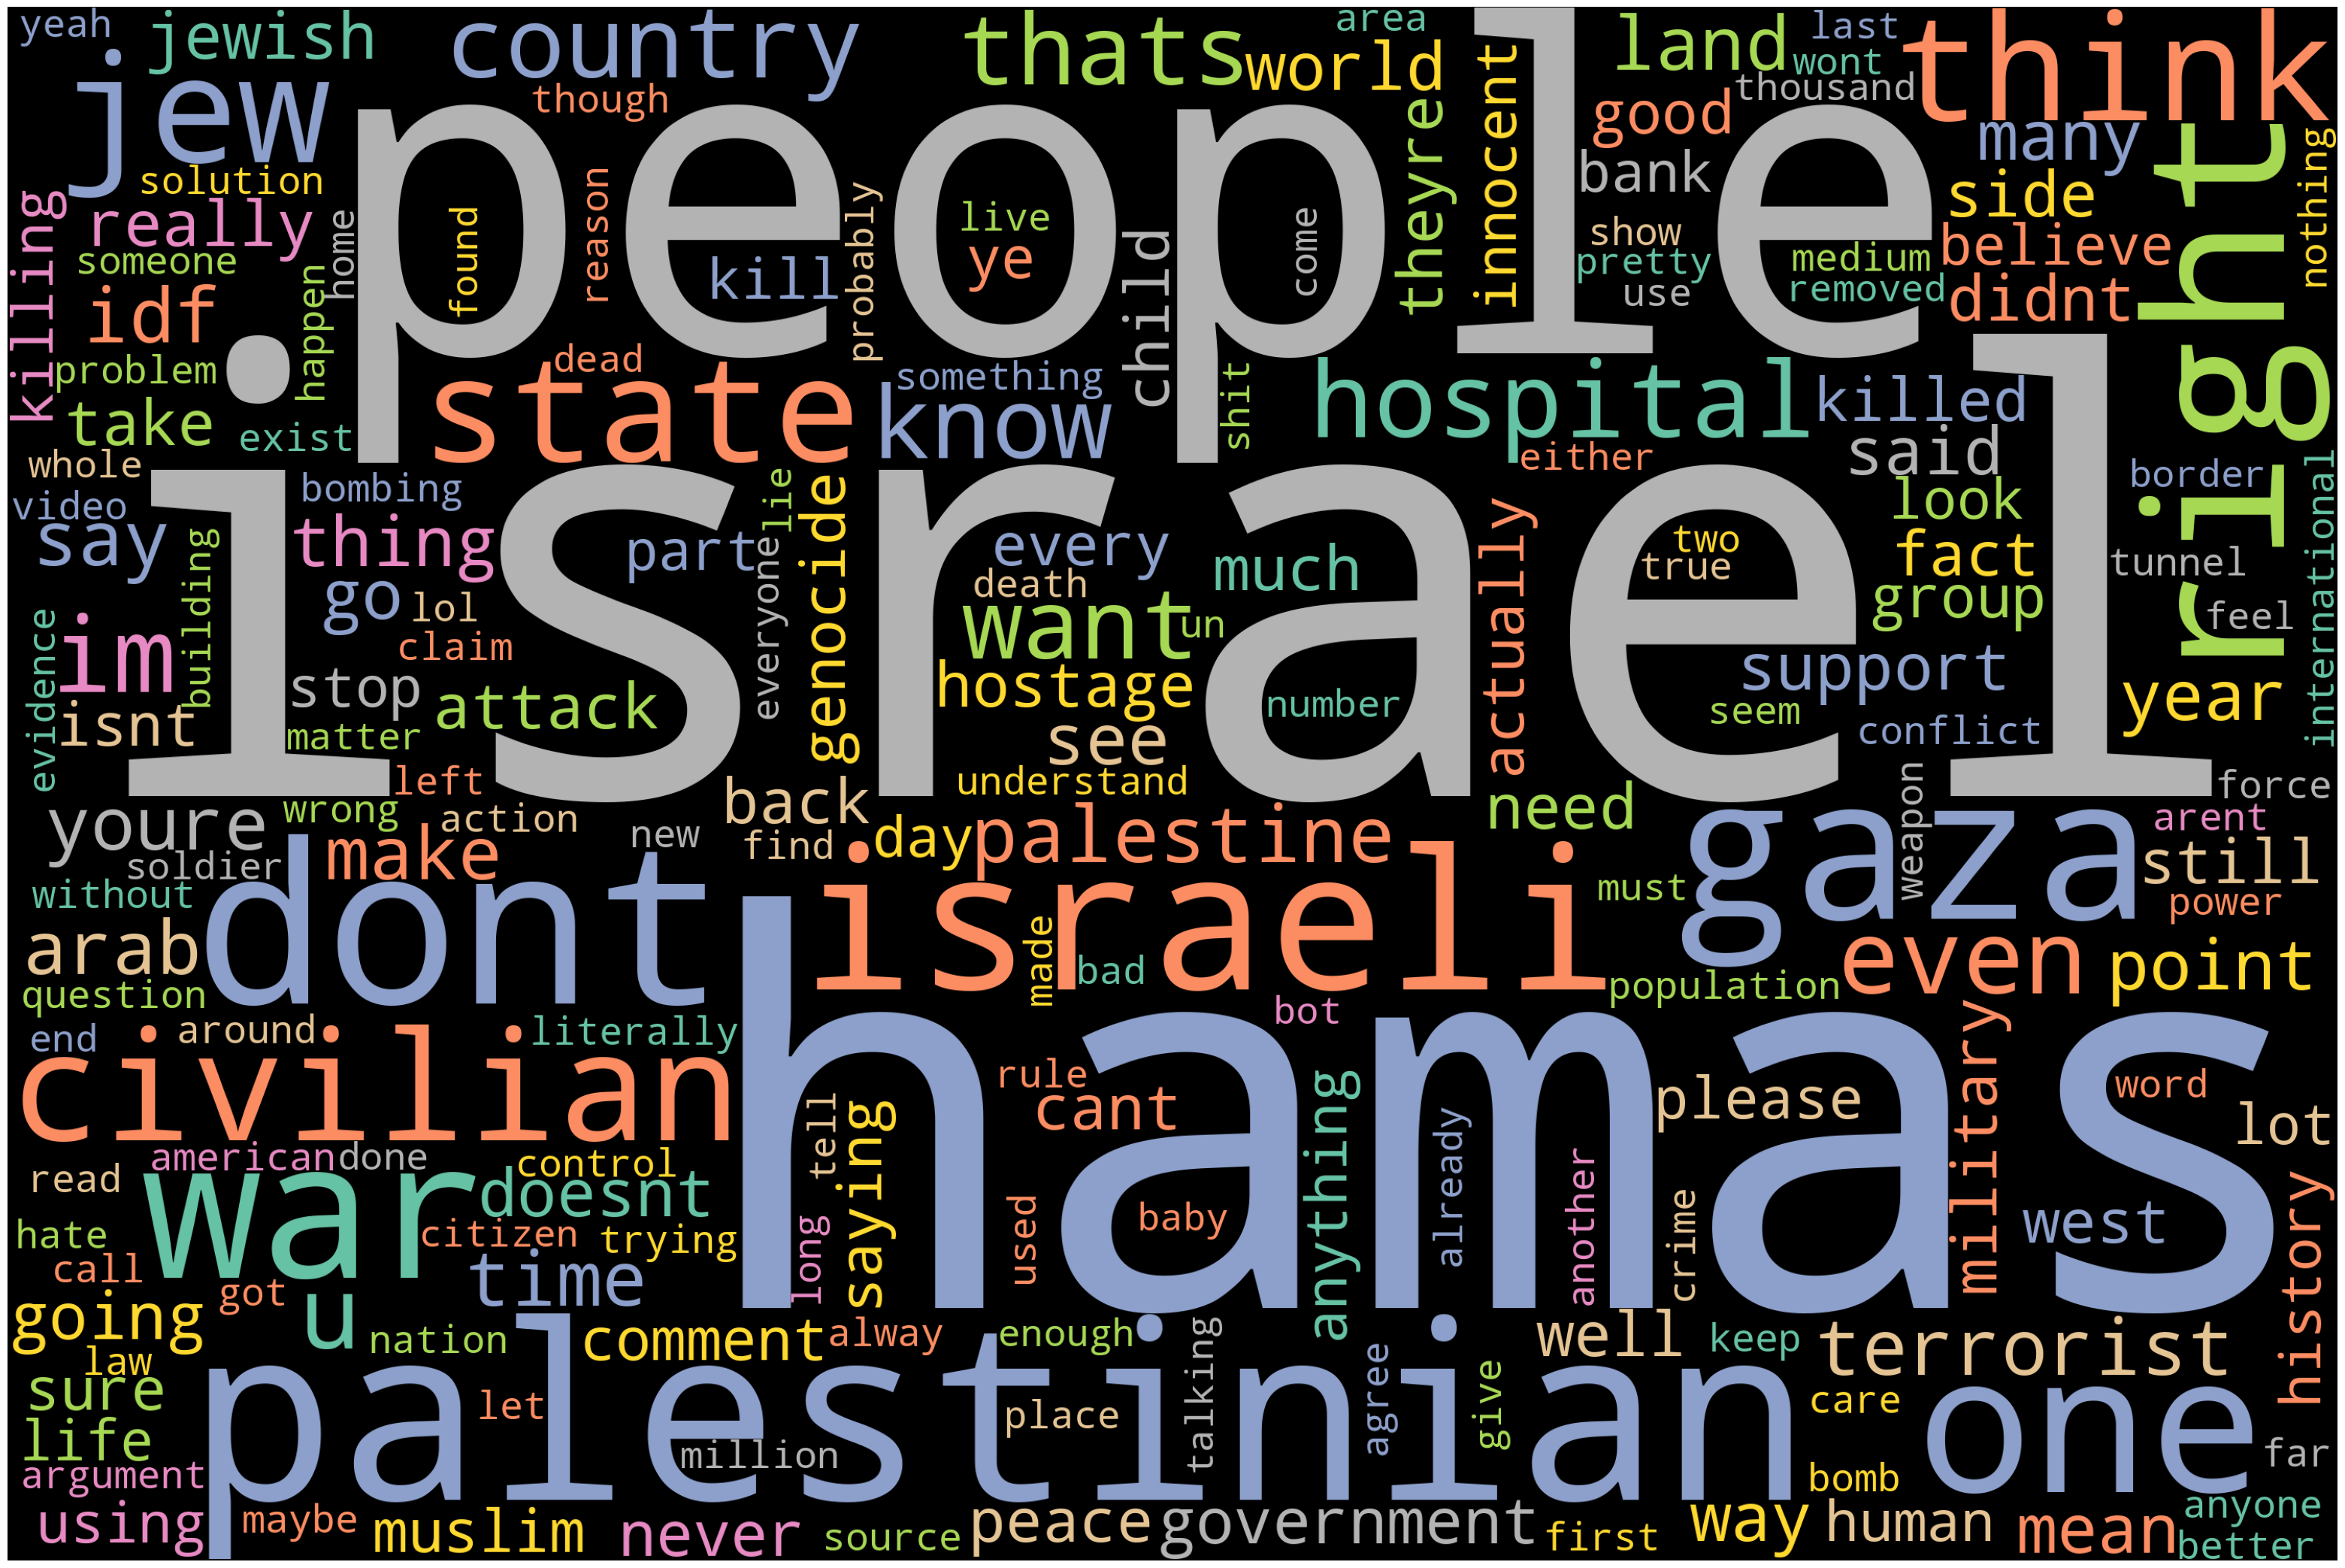

In [ ]:
# Concatenate all comments into a single string
text = " ".join(comment for comment in df.clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### WordCloud of Positive Sentiments

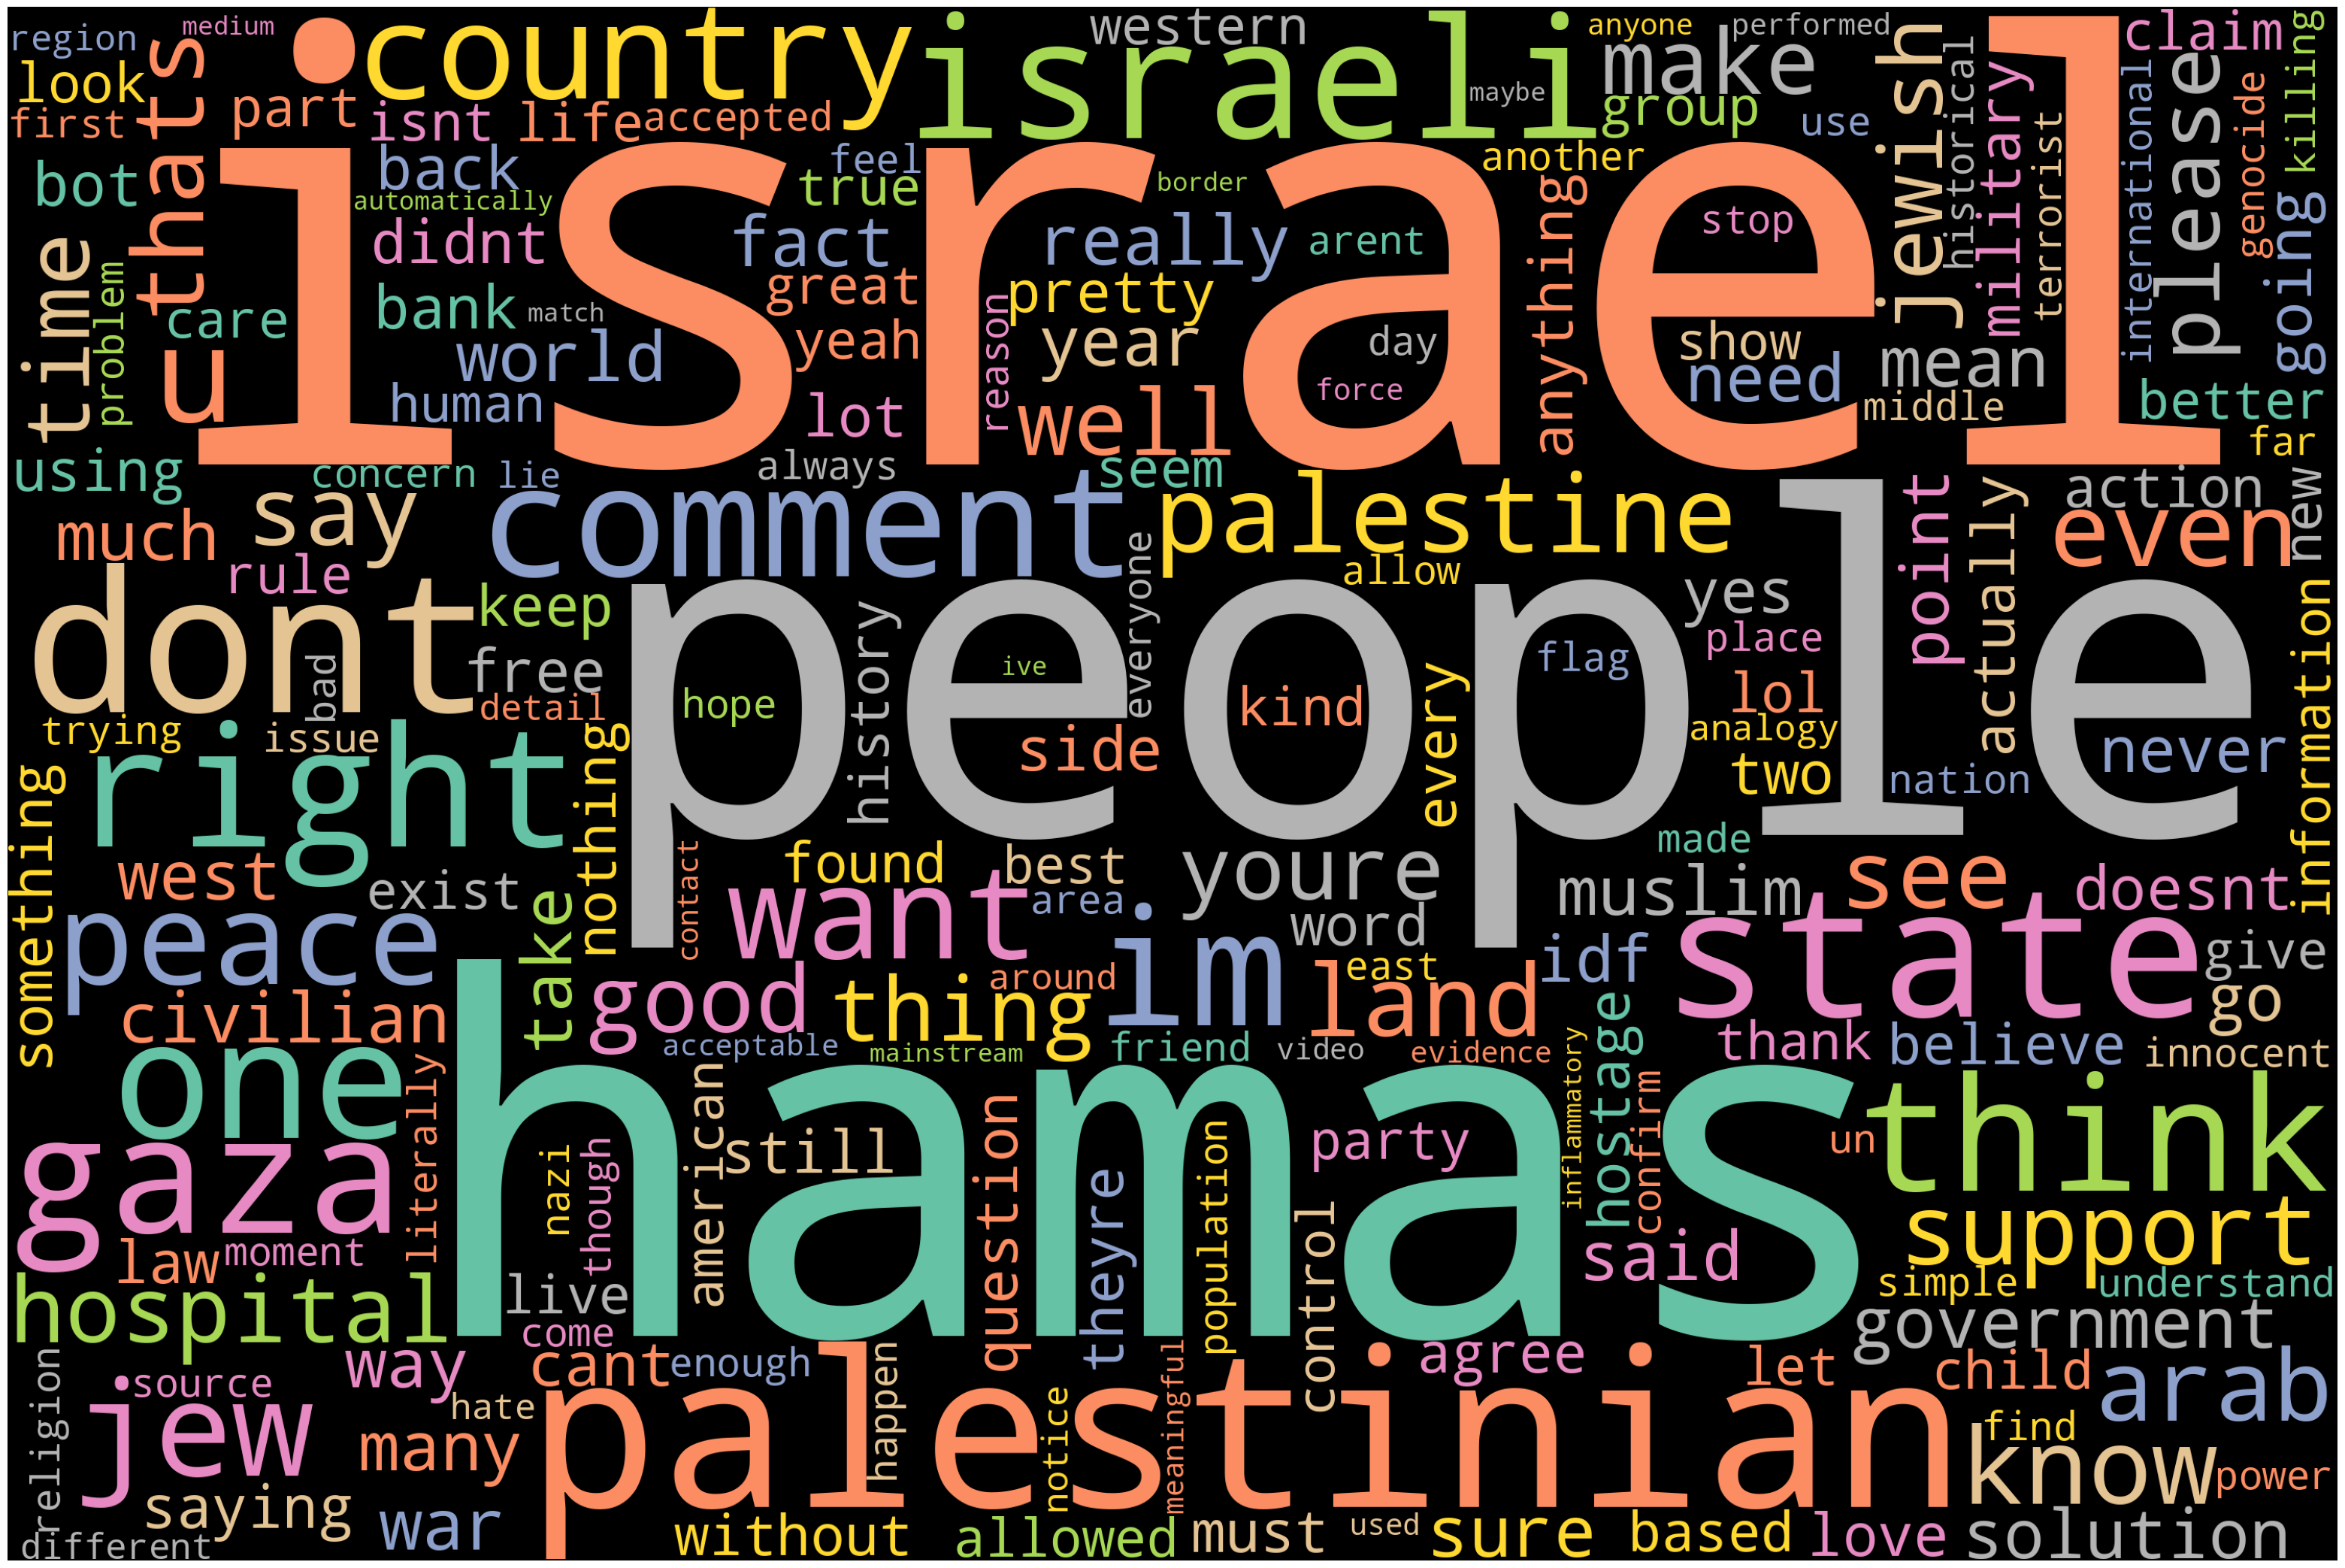

In [ ]:
# Concatenate all comments into a single string
text = " ".join(comment for comment in df[df['Category']=='Positive'].clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


#### WordCloud of Neutral Sentiments

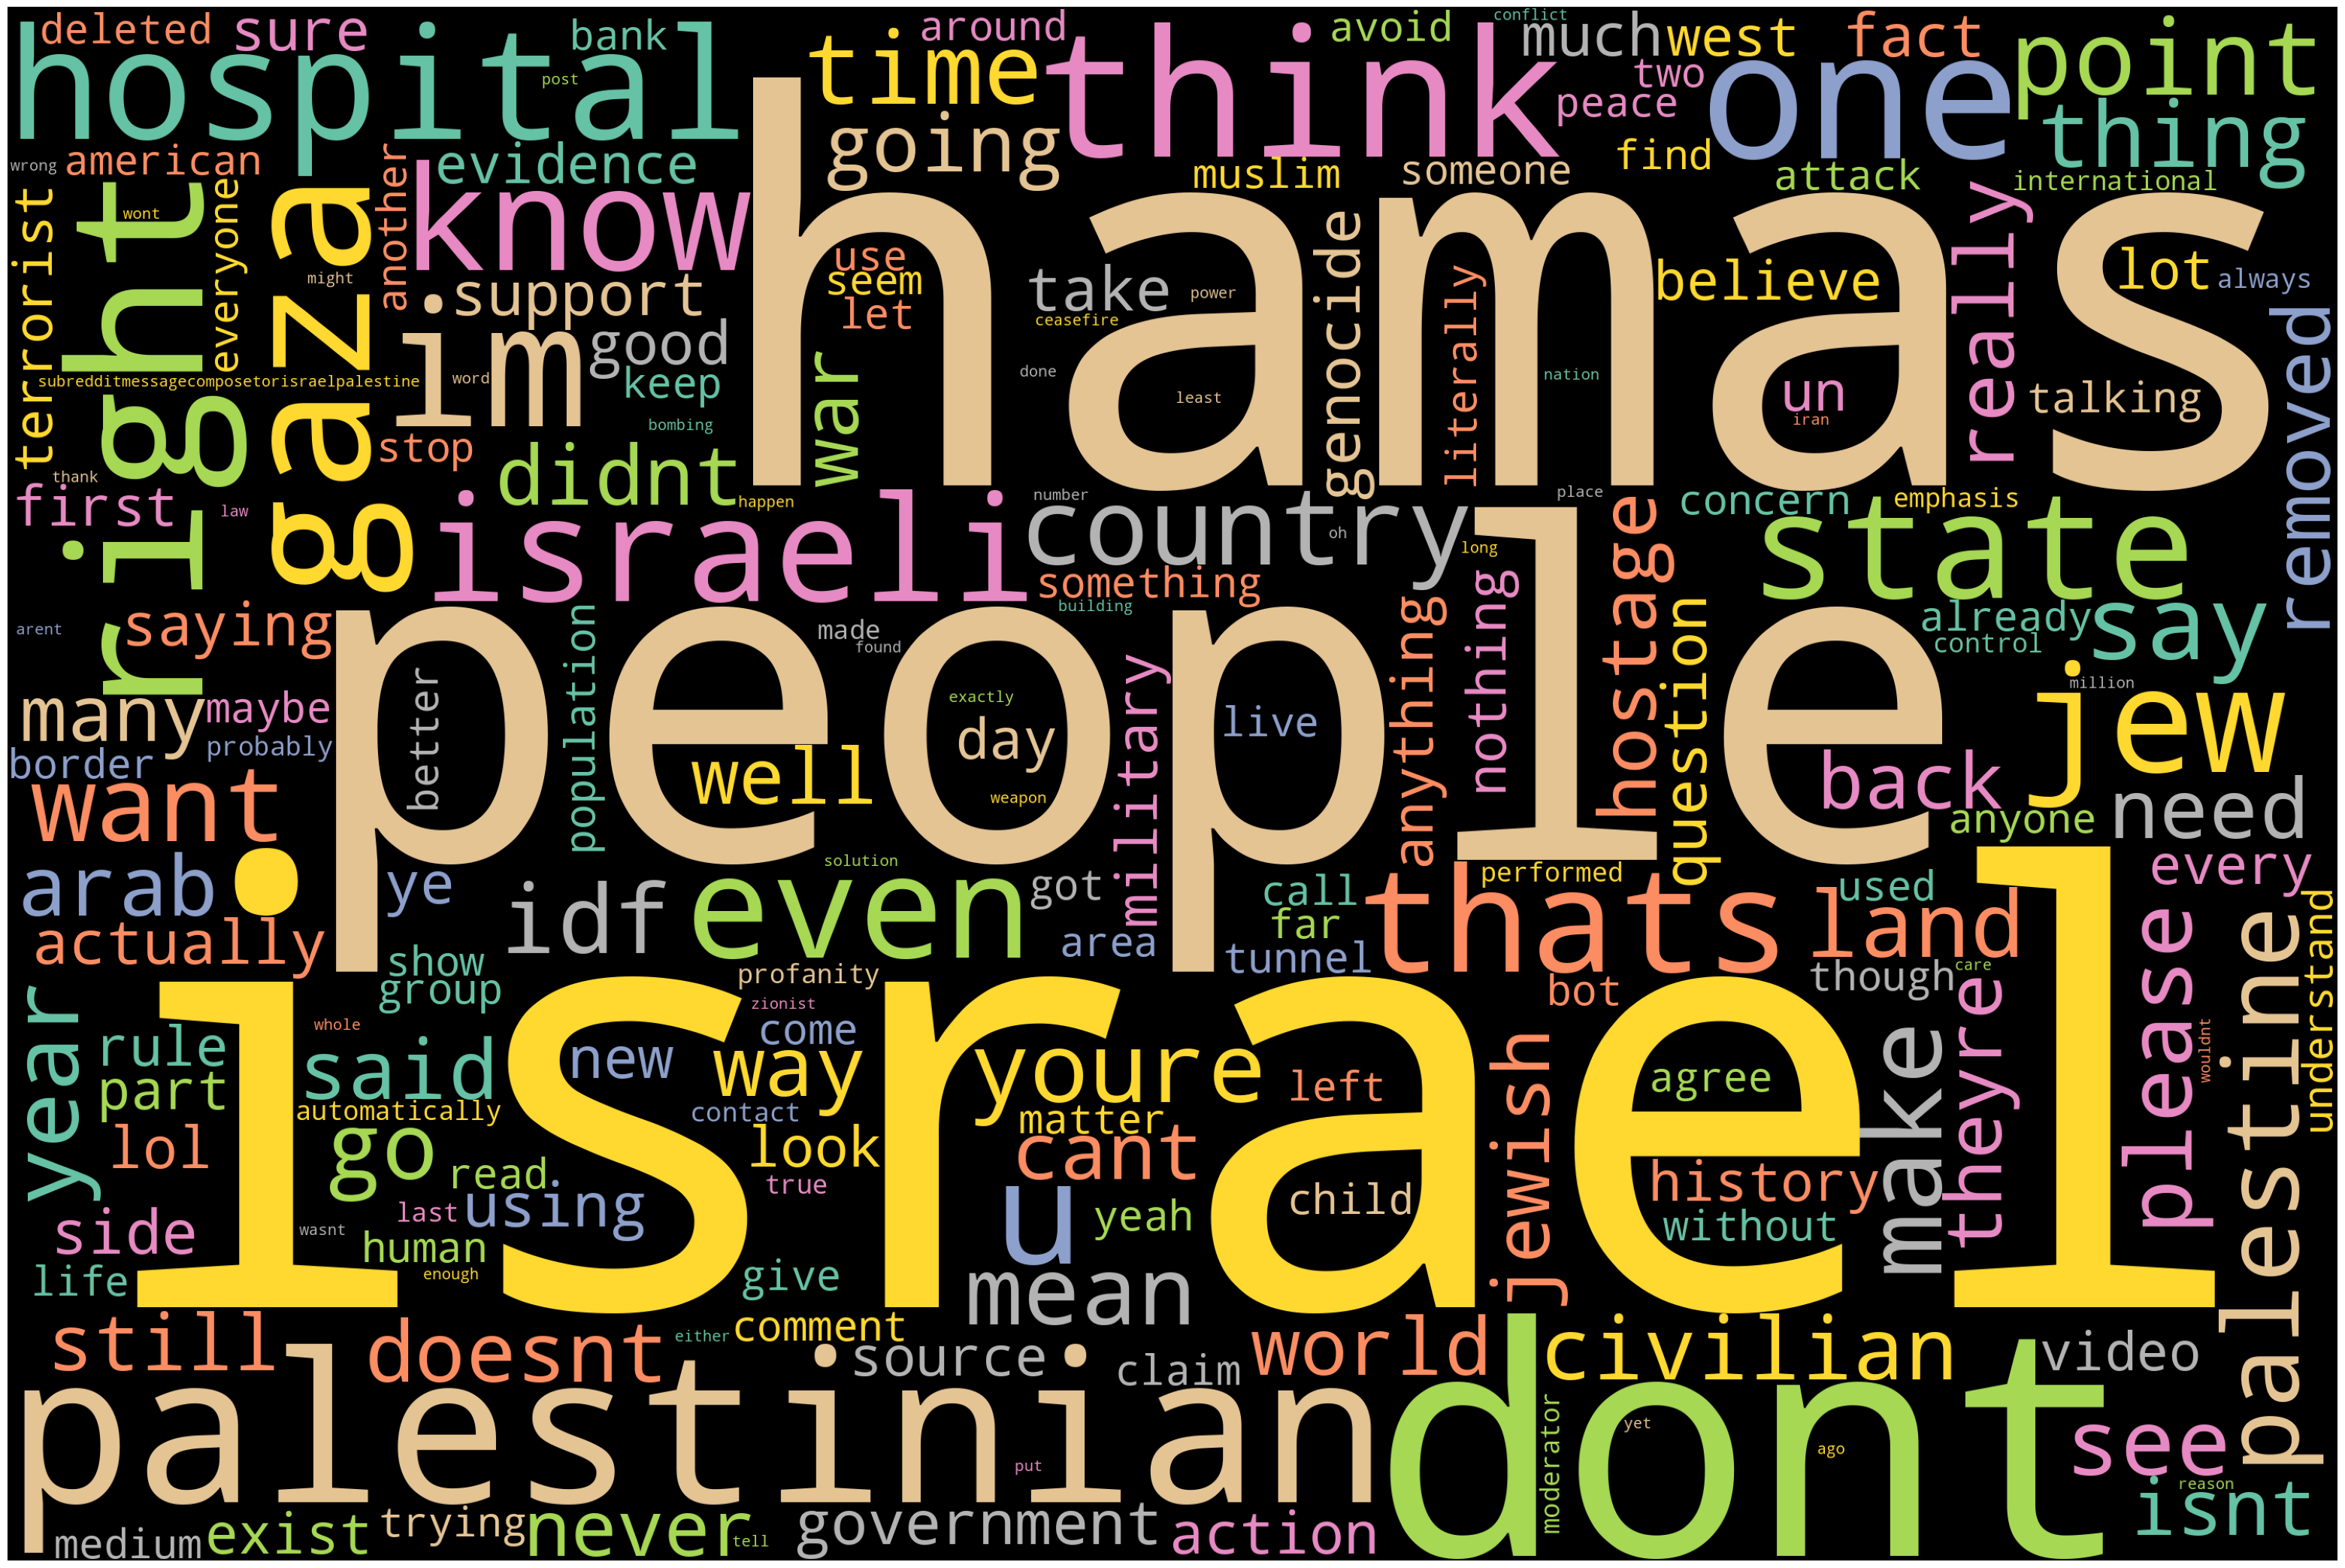

In [ ]:
# Concatenate all comments into a single string
text = " ".join(comment for comment in df[df['Category']=='Neutral'].clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### WordCloud of Negative Sentiments

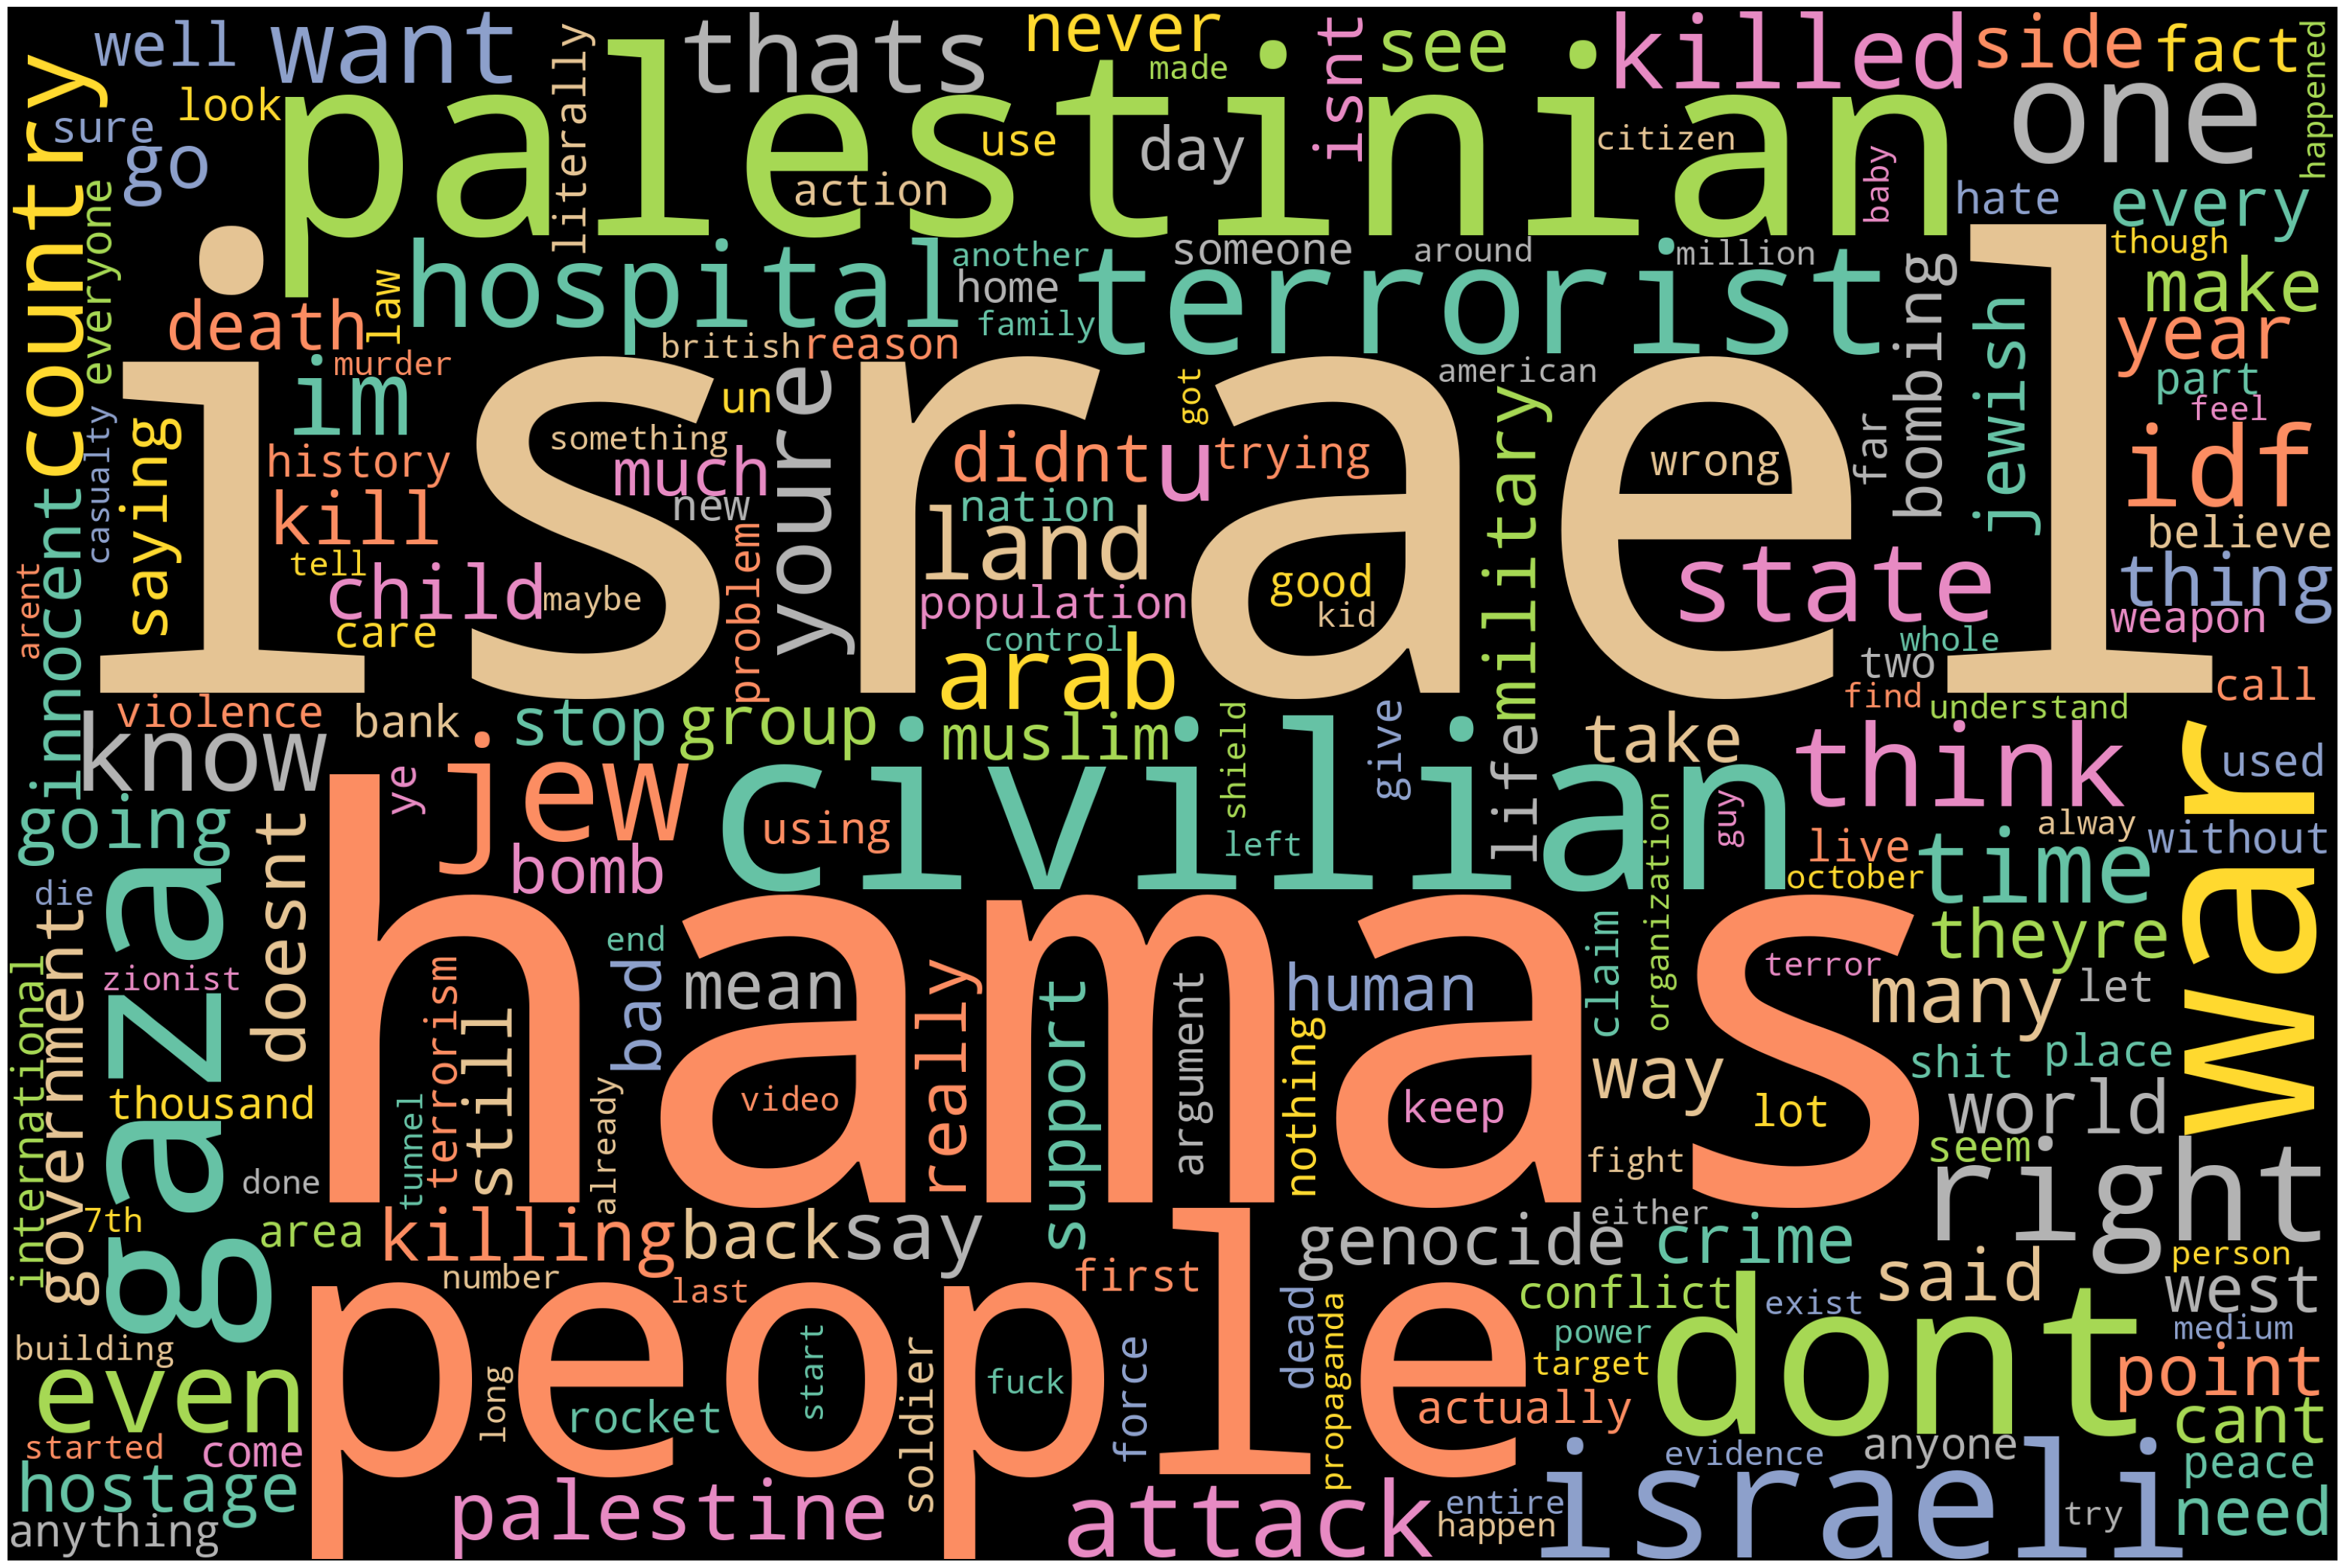

In [ ]:
# Concatenate all comments into a single string
text = " ".join(comment for comment in df[df['Category']=='Negative'].clean_text)

# Create a WordCloud object
wordcloud = WordCloud(width=3000, height=2000, stopwords=STOPWORDS, background_color="black",
                      colormap='Set2', collocations=False).generate_from_text(text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display the generated word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Positive or Negative Bias Detection

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['clean_text'])
lda_model = LatentDirichletAllocation(n_components=5, random_state=42, n_jobs=-1)  # Assuming 5 topics
lda_topic_matrix = lda_model.fit_transform(tfidf_matrix)

#### Topic Modelling

In [ ]:
# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the top words for each topic
n_top_words = 10  # You can adjust this number to display more or fewer words per topic
top_words_per_topic = []
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_words_per_topic.append(top_words)

# Print the topics and associated words
for topic_idx, top_words in enumerate(top_words_per_topic):
    print(f"Topic #{topic_idx + 1}:")
    print(", ".join(top_words))
    print()

Topic #1:
removed, source, im, good, thank, post, read, dont, sure, oh

Topic #2:
hospital, idf, hamas, tunnel, hostage, evidence, video, point, know, using

Topic #3:
israel, hamas, palestinian, people, gaza, civilian, war, state, israeli, dont

Topic #4:
deleted, comment, dont, genocide, like, youre, exactly, bot, people, say

Topic #5:
jew, land, people, israel, arab, palestine, right, palestinian, jewish, country



In [ ]:
# Get the vocabulary indices for 'israel' and 'palestine' in your vectorizer
israel_word_index = vectorizer.vocabulary_['israel']
palestine_word_index = vectorizer.vocabulary_['palestine']

In [ ]:
topic_term_distribution = lda_model.components_

In [ ]:
israel_topic_index = topic_term_distribution[:, israel_word_index].argmax()
palestine_topic_index = topic_term_distribution[:, palestine_word_index].argmax()

In [ ]:
# Define the function to determine geopolitical stance
def determine_geopolitical_stance(row):
    sentiment_score = row['Compound']
    topic_distribution = lda_model.transform(vectorizer.transform([row['clean_text']]))[0]

    # Determine stance based on sentiment score and dominant topic
    if sentiment_score <= -0.5:
        return 'Against Israel/Palestine'
    elif sentiment_score >= 0.5 and topic_distribution.argmax() == israel_topic_index:
        return 'Supports Israel'
    elif sentiment_score >= 0.5 and topic_distribution.argmax() == palestine_topic_index:
        return 'Supports Palestine'
    else:
        return 'Neutral/Stance Not Clear'

# Apply the function to the DataFrame to determine geopolitical stances
df['geopolitical_stance'] = df.apply(determine_geopolitical_stance, axis=1)

In [ ]:
stance_counts = df['geopolitical_stance'].value_counts()
print("Geopolitical Stance Distribution:")
print(stance_counts)

Geopolitical Stance Distribution:
Neutral/Stance Not Clear    12896
Against Israel/Palestine     5878
Supports Israel              1352
Name: geopolitical_stance, dtype: int64


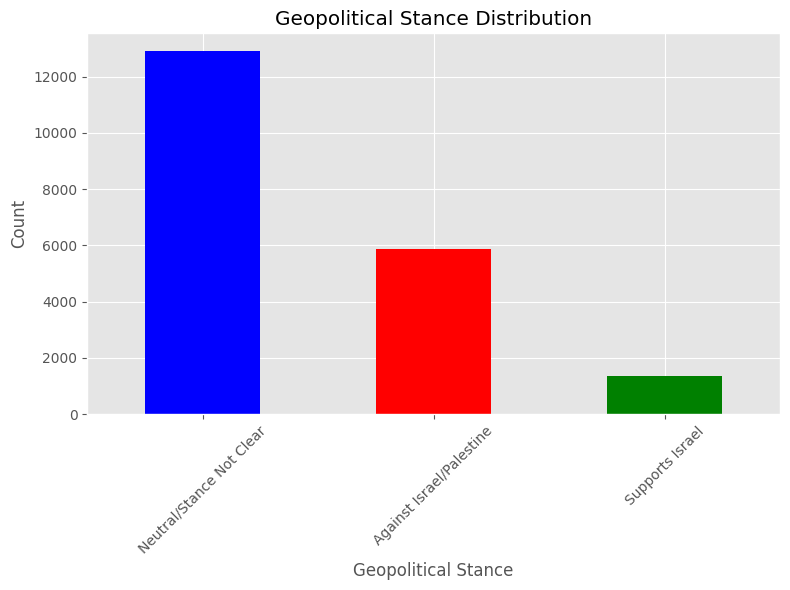

In [ ]:
# Assuming 'geopolitical_stance' is a column in your DataFrame df
stance_counts = df['geopolitical_stance'].value_counts()

# Create bar chart using DataFrame values
plt.figure(figsize=(8, 6))
stance_counts.plot(kind='bar', color=['blue', 'red', 'green', 'yellow'])
plt.xlabel('Geopolitical Stance')
plt.ylabel('Count')
plt.title('Geopolitical Stance Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the chart
plt.show()

#### Geopolitical Stance Distribution:

- Neutral/Stance Not Clear: The majority of the data falls into this category with a count of 12,865. This suggests that a significant portion of the dataset does not express a clear geopolitical stance on the Israel-Palestine issue.

- Against Israel/Palestine: There are 5917 instances where the stance is against Israel/Palestine. This indicates a substantial portion of the data expressing a negative sentiment or opposition towards Israel, Palestine, or both.

- Supports Palestine: There are no instances where the stance supports Palestine. This dataset represents not notable segment of the data that expresses support for the Palestinian side of the conflict.

- Supports Israel: There are 1344 instances where the stance supports Israel. Similar to supporting Palestine, supporting Israel is also expressed by a smaller but significant portion of the dataset.

In summary, the majority of the data does not express a clear stance. Among those that do, there is a considerable diversity of opinions, with a slightly higher number of instances leaning against Israel/Palestine.

In [ ]:
df.head()

comments  \
0  This is not a political battle ground subreddi...   
1  I believe "release the hostages" has passed th...   
2  I think the fact that it happened so far away ...   
3  I mean, pretty sure it's just assumed that eve...   
4  If Hamas were to release the hostages and turn...   

                                          clean_text  Compound  Positive  \
0  not political battle ground subreddit please r...    0.6988     0.220   
1  believe release hostage passed lip everyone iv...    0.0000     0.000   
2  think fact happened far away help people suppo...    0.3182     0.124   
3  mean pretty sure assumed everyone want terrori...   -0.9186     0.215   
4  hamas release hostage turn war would tragedy h...   -0.6486     0.185   

   Negative  Neutral  Category       geopolitical_stance  
0     0.000    0.780  Positive  Neutral/Stance Not Clear  
1     0.000    1.000   Neutral  Neutral/Stance Not Clear  
2     0.071    0.805   Neutral  Neutral/Stance Not Clear  
3     0.563    0.222  Negative  Against Israel/Palestine  
4     0.217    0.598  Negative  Against Israel/Palestine

In [ ]:
#corpus=list(df['clean_text'])

In [ ]:
corpus[0:2]

['not political battle ground subreddit please read rule commenting total karma account age threshold required post comment bot action performed automatically please contact moderator subreddit message compose r breakingpointsnews question concern',
 'believe release hostage passed lip everyone talked hanging different experience']

In [ ]:
max([[i,j] for i,j in zip(list(map(len,corpus)),corpus)])

[5100,
 'outright ahistorical israeli propaganda tldr time people call peace negotiation palestinian delegation israel requested ridiculous thing like access water supply complete demilitarization airspace control movement control right army ground control agricultural land gaza ridiculous amount land historical significant city palestinian always wanting expand settlement cashing tva almost none time important issue like border future palestinian state status jerusalem right return palestinian refugee fate israeli settlement discussed sane delegation country would accept another country much control 1949 armistice palestinian not direct representation negotiation armistice halt fighting not peace settlement 1967 allon plan palestinian not direct representation included significant territorial expansion west bank gaza strip made enable israeli annexation east jerusalem etzion bloc jordan valley remaining part west bank containing majority palestinian returned jordan roger plan palestin

In [ ]:
voc_size=23000
sent_length=750
embedding_vector_features=40

In [ ]:
onehot_repr=[one_hot(words,voc_size) for words in corpus]
onehot_repr[1]

[15167, 7661, 16497, 1220, 11946, 18265, 19325, 3942, 21002, 4328]

In [ ]:
corpus[1]

'believe release hostage passed lip everyone talked hanging different experience'

In [ ]:
embedded_doc=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

In [ ]:
embedded_doc[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
X=np.array(embedded_doc)

In [ ]:
X.shape

(20126, 750)

In [ ]:
le = LabelEncoder()
le.fit(df['geopolitical_stance'])
y=le.transform(df['geopolitical_stance'])

In [ ]:
y.shape

(20126,)

#### Splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# one-hot encoding of labels
y_train1 = to_categorical(y_train, num_classes=3)
y_test1 = to_categorical(y_test, num_classes=3)

#### Bulding,Training, Tuning and Evaluating the Model

In [ ]:
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(500,return_sequences=True)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(400))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 750, 40)           920000    
                                                                 
 dropout_3 (Dropout)         (None, 750, 40)           0         
                                                                 
 batch_normalization (Batch  (None, 750, 40)           160       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 750, 1000)         2164000   
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 750, 1000)         0         
                                                                 
 batch_normalization_1 (Bat  (None, 750, 1000)        

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
model_history = model.fit(X_train, y_train1, validation_data = (X_test,y_test1), epochs=100, batch_size = 64, callbacks = [early_stopping])

Epoch 1/100
211/211 [==============================] - 195s 892ms/step - loss: 0.9279 - accuracy: 0.6078 - val_loss: 1.5828 - val_accuracy: 0.6372
Epoch 2/100
211/211 [==============================] - 181s 857ms/step - loss: 0.6551 - accuracy: 0.7404 - val_loss: 1.3076 - val_accuracy: 0.6372
Epoch 3/100
211/211 [==============================] - 175s 829ms/step - loss: 0.5018 - accuracy: 0.8148 - val_loss: 0.6689 - val_accuracy: 0.7579
Epoch 4/100
211/211 [==============================] - 174s 826ms/step - loss: 0.4155 - accuracy: 0.8494 - val_loss: 0.6665 - val_accuracy: 0.7669
Epoch 5/100
211/211 [==============================] - 151s 716ms/step - loss: 0.3273 - accuracy: 0.8766 - val_loss: 0.6861 - val_accuracy: 0.7600
Epoch 6/100
211/211 [==============================] - 171s 810ms/step - loss: 0.2542 - accuracy: 0.9052 - val_loss: 0.7447 - val_accuracy: 0.7534
Epoch 7/100
211/211 [==============================] - 171s 813ms/step - loss: 0.2064 - accuracy: 0.9252 - val_loss: 0

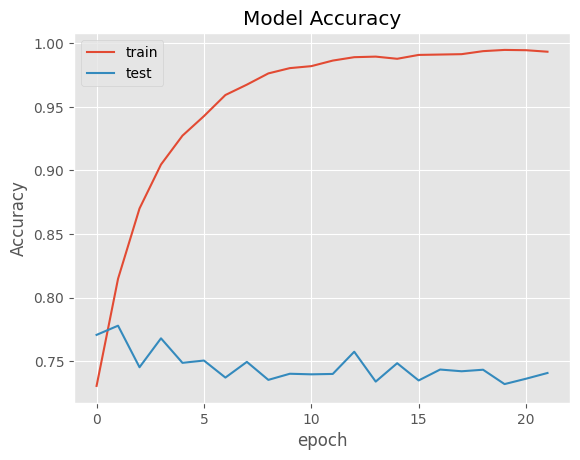

In [ ]:
plt.plot(model_history.history[ 'accuracy'])
plt.plot(model_history.history[ 'val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()

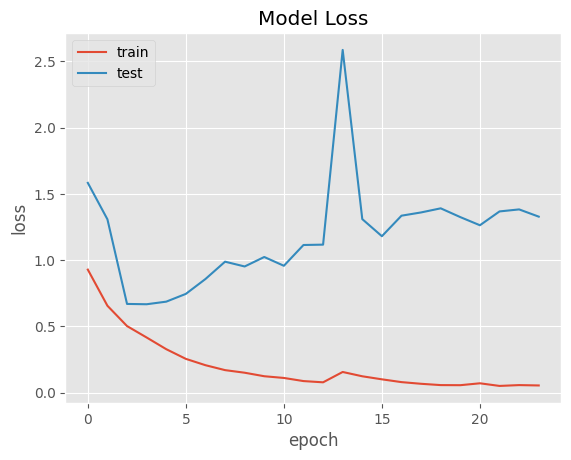

In [ ]:
plt.plot(model_history.history[ 'loss'])
plt.plot(model_history.history[ 'val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_pred=model.predict(X_test)

208/208 [==============================] - 27s 125ms/step


In [ ]:
y_pred=np.argmax(y_pred, axis=-1)

In [ ]:
confusion_matrix(y_test,y_pred)

array([[1275,  558,  143],
       [ 482, 3501,  249],
       [  90,  203,  141]])

In [ ]:
accuracy_score(y_test,y_pred)

0.7402890695573623

In [ ]:
print(classification_report(y_test,y_pred))  ## Confusion matrix for validation data

              precision    recall  f1-score   support

           0       0.69      0.65      0.67      1976
           1       0.82      0.83      0.82      4232
           2       0.26      0.32      0.29       434

    accuracy                           0.74      6642
   macro avg       0.59      0.60      0.59      6642
weighted avg       0.75      0.74      0.74      6642



In [ ]:
def model_builder(hp):
  model =Sequential()
  hp_dim = hp.Int('dim', min_value=32, max_value=256, step=64)
  model.add(Embedding(voc_size, hp_dim, input_length=sent_length))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 500-2000
  hp_units1 = hp.Int('units1', min_value=300, max_value=500, step=100)
  model.add(Bidirectional(LSTM(hp_units1,return_sequences=True)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  hp_units2 = hp.Int('units2', min_value=300, max_value=500, step=100)
  model.add(LSTM(hp_units2))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(units=3, activation='softmax'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='Tuner',
                     project_name='Cluster_war')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(X_train, y_train1, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 16 Complete [00h 04m 30s]
val_accuracy: 0.6959584951400757

Best val_accuracy So Far: 0.7612161636352539
Total elapsed time: 01h 04m 29s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
160               |96                |dim
300               |300               |units1
300               |500               |units2
0.001             |0.001             |learning_rate
10                |2                 |tuner/epochs
4                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |0                 |tuner/round
0013              |None              |tuner/trial_id

Epoch 5/10
338/338 [==============================] - 100s 277ms/step - loss: 0.2610 - accuracy: 0.9099 - val_loss: 0.8851 - val_accuracy: 0.7234
Epoch 6/10
338/338 [==============================] - 83s 245ms/step - loss: 0.1635 - accuracy: 0.9456 - val_loss: 1.0770 - val_accuracy: 0.7160
Epoch 7/10
338/338 [================

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the Bidirectional LSTM
layer is {best_hps.get('units1')} and The optimal number of units in the LSTM
layer is {best_hps.get('units2')} andthe optimal learning rate for the optimizer
is {best_hps.get('learning_rate')} and the optimal number of dimesnion is{best_hps.get('dim')}.
""")

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train1, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train1, epochs=best_epoch, validation_split=0.2)

In [ ]:
eval_result = hypermodel.evaluate(X_test, y_test1)
print("[test loss, test accuracy]:", eval_result)